In [1]:
pip install -U keras-tuner

     |████████████████████████████████| 61kB 2.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=4d77b0c7259f89931229d2244d24181bb00a52e97b0ceb35cd18f33ae05e2dea
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=fe445e206092afe48ddbf7be9c32a44d0d62efc0106e0021d682576024f3756f
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd drive/My\ Drive/Projects/TimeSeriesForecasting

/content/drive/My Drive/Projects/TimeSeriesForecasting


In [0]:
import os
import json
import numpy as np
import pandas as po
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [0]:
import tensorflow as tf
from kerastuner.tuners.bayesian import BayesianOptimization

In [0]:
os.makedirs('forecasts', exist_ok=True)
os.makedirs('forecasts/full_testing_length', exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time', exist_ok=True)

In [0]:
df = po.read_csv('data/2017_energy_5min_noTransform.csv')

In [0]:
scaler = MinMaxScaler()
df['W'] = scaler.fit_transform(df)

In [0]:
class Args:
  def __init__(self):
    self.val_start = 12*24*250
    self.test_start = 12*24*300
    self.train_seq_len = 12*24*7
    self.val_seq_len = 12*24
    
    self.batch_size = 256
    self.num_epochs = 25
    self.save_folder = 'tune_convLSTM'
    
    self.subsequences = self.train_seq_len//(12*24)
    #self.conv_num_channels = 128
    #self.kernel_size = (1, 12)
    
    self.logs_dir = 'model_checkpoints/' + self.save_folder + '/logs_dir'

In [0]:
args = Args()

In [0]:
os.makedirs('plots/' + args.save_folder, exist_ok=True)
os.makedirs('model_checkpoints/' + args.save_folder, exist_ok=True)
os.makedirs('model_checkpoints/' + args.save_folder + '/logs_dir', exist_ok=True)
os.makedirs('forecasts/full_testing_length/' + args.save_folder, exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder, exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder + '/plots', exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder + '/tabulated_results', exist_ok=True)

In [0]:
train_df = df[: args.val_start]
val_df = df[args.val_start: args.test_start]
test_df = df[args.test_start:]

In [0]:
def make_windows(data, train_seq_len = args.train_seq_len, val_seq_len = args.val_seq_len):
    X = []
    y = []

    for i in tqdm(range(train_seq_len, len(data) - val_seq_len + 1)):    
        X.append(data.values[i - train_seq_len: i].T.tolist())
        y.append(data.values[i: i + val_seq_len].T.tolist())

    X = np.array(X).squeeze().reshape(-1, train_seq_len, 1)
    y = np.array(y).squeeze()

    return X, y

In [14]:
X_train, y_train = make_windows(train_df)
X_val, y_val = make_windows(val_df)
X_test, y_test = make_windows(test_df)

100%|██████████| 12097/12097 [00:01<00:00, 9448.55it/s]


In [0]:
X_train = X_train.reshape(X_train.shape[0], args.subsequences, 1, -1, 1)
X_val = X_val.reshape(X_val.shape[0], args.subsequences, 1, -1, 1)
X_test = X_test.reshape(X_test.shape[0], args.subsequences, 1, -1, 1)

In [0]:
sgd = tf.keras.optimizers.SGD(lr=0.1, decay=1e-2, momentum=0.9, nesterov=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2)
#best_val = tf.keras.callbacks.ModelCheckpoint('model_checkpoints/' + args.save_folder + '/model_{epoch:02d}.h5', save_best_only=True, mode='min', save_freq='epoch')

In [0]:
def build_model(hp):

  num_channels = hp.Int('num_channels', min_value=25, max_value=200, step=50)
  kernel_size = hp.Int('kernel_size', min_value=6, max_value=36, step=6)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.ConvLSTM2D(filters = num_channels, kernel_size = (1, kernel_size), activation = 'relu', input_shape = (args.subsequences, 1, X_train.shape[3], 1)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(args.val_seq_len))
  model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mean_squared_error'])

  return model

In [0]:
tuner = BayesianOptimization(
    build_model,
    objective='mean_squared_error',
    max_trials=20,
    executions_per_trial=2,
    directory=args.logs_dir,
    project_name=args.save_folder,
    overwrite = True)

In [19]:
tuner.search_space_summary()

In [0]:
tuner.search(X_train, y_train, batch_size = args.batch_size, epochs = args.num_epochs, validation_data = (X_val, y_val), callbacks = [earlystop], verbose=True)

Epoch 1/25
273/273 [==============================] - 295s 1s/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 2/25
273/273 [==============================] - 295s 1s/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 3/25
273/273 [==============================] - 294s 1s/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 4/25
273/273 [==============================] - 295s 1s/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 5/25
273/273 [==============================] - 294s 1s/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 6/25
273/273 [==============================] - 295s 1s/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 7/25
273/273 [==

Epoch 1/25
273/273 [==============================] - 144s 527ms/step - loss: 0.0884 - mean_squared_error: 0.0884 - val_loss: 0.0255 - val_mean_squared_error: 0.0255
Epoch 2/25
273/273 [==============================] - 144s 527ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.0191 - val_mean_squared_error: 0.0191
Epoch 3/25
273/273 [==============================] - 144s 526ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 4/25
273/273 [==============================] - 144s 527ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0147 - val_mean_squared_error: 0.0147
Epoch 5/25
273/273 [==============================] - 144s 527ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 6/25
273/273 [==============================] - 144s 527ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoc

Epoch 1/25
273/273 [==============================] - 20s 74ms/step - loss: 0.1195 - mean_squared_error: 0.1195 - val_loss: 0.1024 - val_mean_squared_error: 0.1024
Epoch 2/25
273/273 [==============================] - 20s 73ms/step - loss: 0.1088 - mean_squared_error: 0.1088 - val_loss: 0.0895 - val_mean_squared_error: 0.0895
Epoch 3/25
273/273 [==============================] - 20s 73ms/step - loss: 0.0850 - mean_squared_error: 0.0850 - val_loss: 0.0578 - val_mean_squared_error: 0.0578
Epoch 4/25
273/273 [==============================] - 20s 73ms/step - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0287 - val_mean_squared_error: 0.0287
Epoch 5/25
273/273 [==============================] - 20s 73ms/step - loss: 0.0269 - mean_squared_error: 0.0269 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 6/25
273/273 [==============================] - 20s 73ms/step - loss: 0.0237 - mean_squared_error: 0.0237 - val_loss: 0.0220 - val_mean_squared_error: 0.0220
Epoch 7/25
273/2

In [0]:
tuner.results_summary()

In [0]:
models = tuner.get_best_models(num_models=1)

In [0]:
best_model = models[0]

In [0]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 288, 150)    300       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 9, 150)      0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1350)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               580400    
_________________________________________________________________
dense (Dense)                (None, 288)               29088     
Total params: 609,788
Trainable params: 609,788
Non-trainable params: 0
_________________________________________________________________


In [0]:
best_model.save_weights('model_checkpoints/' + args.save_folder + '/best_model.h5')

In [0]:
X_test, y_test = make_windows(test_df)

100%|██████████| 12097/12097 [00:01<00:00, 9157.70it/s]


In [0]:
y_pred = model.predict(X_test)

In [0]:
'forecasts/1_day_at_a_time/' + args.save_folder + '/tabulated_results/day_{}.csv'.format(i)

'forecasts/1_day_at_a_time/Dilated_CNN/tabulated_results/day_41.csv'

In [0]:
for i in tqdm(range(y_pred.shape[0]//288)): ## we have forecasts for these many complete day
  plt.plot(scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)), color = 'blue')
  plt.plot(scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)), color = 'red')
  plt.legend(['Actual Value', 'Prediction'])
  plt.savefig('forecasts/1_day_at_a_time/' + args.save_folder + '/plots/day_{}.png'.format(i))
  plt.close()

  df_t = po.DataFrame()
  df_t['Predictions'] = scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)).reshape(-1)
  df_t['Actual_Values'] = scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)).reshape(-1)

  df_t.to_csv('forecasts/1_day_at_a_time/' + args.save_folder + '/tabulated_results/day_{}.csv'.format(i), index = False)

100%|██████████| 42/42 [00:05<00:00,  8.39it/s]


In [0]:
forecasts = []
actuals = []
for i in tqdm(range(y_pred.shape[0]//288)): ## we have forecasts for these many complete day
  forecasts += (scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()
  actuals += (scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()

100%|██████████| 42/42 [00:00<00:00, 3279.97it/s]


In [0]:
df = po.DataFrame()
df['Predictions'] = forecasts
df['Actual Values'] = actuals

In [0]:
df.to_csv('forecasts/full_testing_length/' + args.save_folder + '/full_results.csv', index = False)

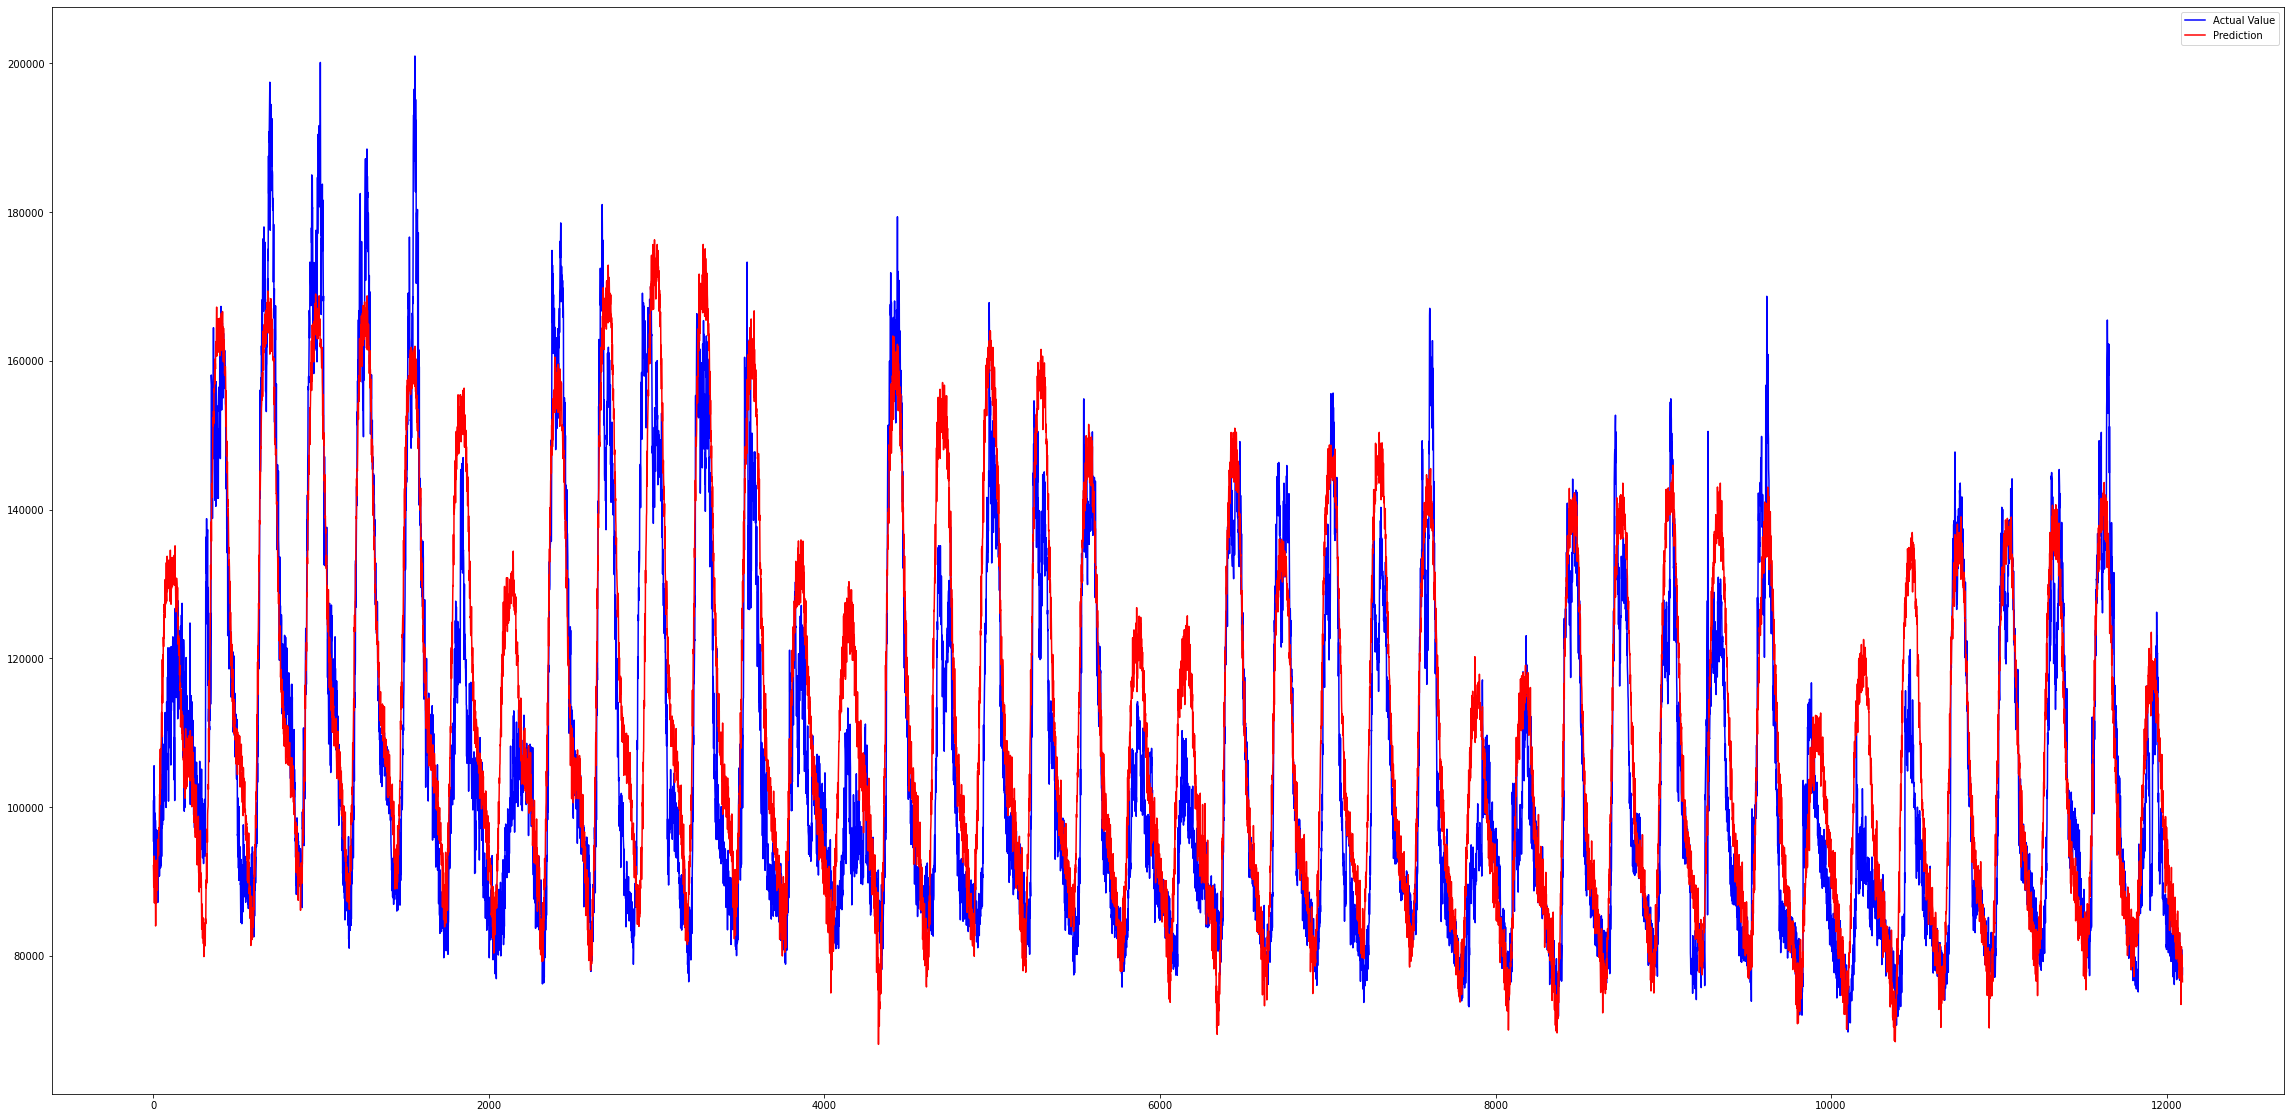

In [0]:
plt.figure(figsize=(40, 20))
plt.plot(actuals, color = 'blue')
plt.plot(forecasts, color = 'red')
plt.legend(['Actual Value', 'Prediction'])
plt.savefig('forecasts/full_testing_length/' + args.save_folder + '/forecast.png')

In [0]:
if not os.path.exists('forecasts/full_testing_length/results.csv'):
  results = po.DataFrame(columns = ['model', 'MAE', 'MSE', 'R2', 'MAPE', 'RMSE'])  
else:
  results = po.read_csv('forecasts/full_testing_length/results.csv')

In [0]:
errors = {'model': args.save_folder,
          'MAE': mean_absolute_error(y_true=y_test, y_pred=y_pred),
          'MAPE': mean_absolute_error(y_true=y_test, y_pred=y_pred)*100,
          'MSE': mean_squared_error(y_true=y_test, y_pred=y_pred),
          'RMSE': mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False),
          'R2': r2_score(y_true=y_test, y_pred=y_pred)          
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)

In [0]:
results

,model,MAE,MSE,R2,MAPE,RMSE
0,Dilated_CNN,0.037945,0.002629,0.732376,3.794527,0.051273


In [0]:
results.to_csv('forecasts/full_testing_length/results.csv', index=False)

In [0]:
with open('forecasts/full_testing_length/' + args.save_folder + '/params.json', 'w') as f:
  f.write(json.dumps(args.__dict__))
f.close()